In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import html

from pathlib import Path

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance, PartialDependenceDisplay
from sklearn.metrics import (
    classification_report,
    roc_auc_score,
    confusion_matrix,
    roc_curve,
    auc,
    precision_recall_curve,
)
from sklearn.feature_selection import mutual_info_classif
from scipy.stats import pointbiserialr

sns.set(style="whitegrid", context="talk", palette="deep")

# =====================================================
# 1. Paths & basic configuration
# =====================================================
root = Path("..").resolve() / "Income-Prediction-Using-Demographic-Data"
raw_path = root / "data" / "raw" / "Adult Dataset"
processed_path = root / "data" / "processed"
processed_path.mkdir(parents=True, exist_ok=True)

REPORTS = root / "reports"
REPORTS.mkdir(parents=True, exist_ok=True)

VISUALS = root / "visuals"
VISUALS.mkdir(parents=True, exist_ok=True)

print(f"[Info] Root: {root}")
print(f"[Info] Processed path: {processed_path}")

# =====================================================
# 2. Load Raw Adult Dataset & Initial Cleaning
# =====================================================

# Column names (Adult dataset)
COLUMNS = [
    "age", "workclass", "fnlwgt", "education",
    "education-num", "marital-status", "occupation",
    "relationship", "race", "sex",
    "capital-gain", "capital-loss",
    "hours-per-week", "native-country", "income",
]

# Load dataset
in_file = raw_path / "adult_data.csv"
if not in_file.exists():
    raise FileNotFoundError(f"Input file not found: {in_file}")

df = pd.read_csv(
    in_file,
    names=COLUMNS,
    sep=",",
    skipinitialspace=True,
    na_values=["?"],
    low_memory=False,
)

print(f"[Info] Loaded raw dataset with {df.shape[0]} rows and {df.shape[1]} columns.")

# Basic cleaning
# ---------------------------

# Convert '?' placeholders to NaN
df.replace("?", np.nan, inplace=True)

# Trim whitespace in all categorical columns
for col in df.select_dtypes(include="object").columns:
    df[col] = df[col].str.strip()

# Remove duplicate rows
before = len(df)
df = df.drop_duplicates().copy()
print(f"[Info] Removed {before - len(df)} duplicate rows.")

# Target variable preparation
TARGET_COL = "income"
HOURS_COL = "hours-per-week"
EDU_YEARS_COL = "education-num"
AGE_COL = "age"

# Normalize target labels (handle trailing dots, HTML artifacts)
df[TARGET_COL] = (
    df[TARGET_COL]
    .apply(html.unescape)
    .str.replace(r"\.$", "", regex=True)
    .str.strip()
)

# Map target to binary
target_mapping = {">50K": 1, "<=50K": 0}
df[TARGET_COL] = df[TARGET_COL].map(target_mapping)

# Validate target mapping
invalid_mask = df[TARGET_COL].isna()
if invalid_mask.any():
    print("\n[Warning] Unmapped target labels detected:")
    print(df.loc[invalid_mask, TARGET_COL].value_counts(dropna=False))

# Drop rows with invalid target
before = len(df)
df = df.dropna(subset=[TARGET_COL]).copy()
print(f"[Info] Dropped {before - len(df)} rows with invalid target labels.")

# Enforce target dtype
df[TARGET_COL] = df[TARGET_COL].astype("int8")

# Numeric type enforcement
NUMERIC_COLS = [
    "age", "fnlwgt", "education-num",
    "capital-gain", "capital-loss", "hours-per-week",
]

df[NUMERIC_COLS] = df[NUMERIC_COLS].apply(pd.to_numeric, errors="coerce")

# Missing value inspection & removal
print("\n[Info] Missing values per column (before dropna):")
print(df.isna().sum())

before = df.shape[0]
df = df.dropna().copy()
print(f"[Info] Dropped {before - df.shape[0]} rows containing missing values.")

# Final dataset summary
print(f"[Info] Final cleaned dataset: {df.shape[0]} rows, {df.shape[1]} columns.")
print("[Info] Target distribution:")
print(df[TARGET_COL].value_counts())

# ---------------------------
# Save early-cleaned dataset
# ---------------------------
early_clean_path = processed_path / "adult.csv"
df.to_csv(early_clean_path, index=False)
print(f"[Info] Saved early-cleaned dataset to: {early_clean_path}")


[Info] Root: C:\Users\jayap\AI\Income-Prediction-Using-Demographic-Data
[Info] Processed path: C:\Users\jayap\AI\Income-Prediction-Using-Demographic-Data\data\processed
[Info] Loaded raw dataset with 32561 rows and 15 columns.
[Info] Removed 24 duplicate rows.
[Info] Dropped 0 rows with invalid target labels.

[Info] Missing values per column (before dropna):
age                  0
workclass         1836
fnlwgt               0
education            0
education-num        0
marital-status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country     582
income               0
dtype: int64
[Info] Dropped 2398 rows containing missing values.
[Info] Final cleaned dataset: 30139 rows, 15 columns.
[Info] Target distribution:
income
0    22633
1     7506
Name: count, dtype: int64
[Info] Saved early-cleaned dataset to: C:\Users\jayap\AI\Income-Prediction-Using-Demographi

In [3]:
# =====================================================
# 4. Outlier removal & final clean dataset (df_clean)
# =====================================================

def iqr_filter(data: pd.DataFrame, col: str, k: float = 1.5) -> pd.DataFrame:
    Q1, Q3 = data[col].quantile([0.25, 0.75])
    IQR = Q3 - Q1
    lower = Q1 - k * IQR
    upper = Q3 + k * IQR
    return data[(data[col] >= lower) & (data[col] <= upper)]

df_clean = df.copy()

# -----------------------------------------------------
# Apply IQR ONLY to statistically appropriate variables
# -----------------------------------------------------
for col in [AGE_COL, EDU_YEARS_COL]:
    if col in df_clean.columns and np.issubdtype(df_clean[col].dtype, np.number):
        before = df_clean.shape[0]
        df_clean = iqr_filter(df_clean, col, k=1.5)
        print(f"[Info] {col}: removed {before - df_clean.shape[0]} outliers (IQR rule).")

# -----------------------------------------------------
# Domain-based sanity filtering for hours-per-week
# -----------------------------------------------------
if HOURS_COL in df_clean.columns:
    before = df_clean.shape[0]
    df_clean = df_clean[
        (df_clean[HOURS_COL] >= 1) & (df_clean[HOURS_COL] <= 99)
    ]
    print(f"[Info] {HOURS_COL} domain filter: removed {before - df_clean.shape[0]} rows.")

# -----------------------------------------------------
# Age sanity filter (defensive check)
# -----------------------------------------------------
if AGE_COL in df_clean.columns:
    before = df_clean.shape[0]
    df_clean = df_clean[
        (df_clean[AGE_COL] >= 16) & (df_clean[AGE_COL] <= 90)
    ]
    print(f"[Info] {AGE_COL} sanity filter: removed {before - df_clean.shape[0]} rows.")

print("[Info] Remaining rows after outlier removal:", df_clean.shape[0])

# -----------------------------------------------------
# Save final cleaned dataset
# -----------------------------------------------------
cleaned_path = processed_path / "adult_cleaned.csv"
df_clean.to_csv(cleaned_path, index=False)
print(f"[Info] Saved final cleaned CSV to: {cleaned_path}")


[Info] age: removed 168 outliers (IQR rule).
[Info] education-num: removed 190 outliers (IQR rule).
[Info] hours-per-week domain filter: removed 0 rows.
[Info] age sanity filter: removed 0 rows.
[Info] Remaining rows after outlier removal: 29781
[Info] Saved final cleaned CSV to: C:\Users\jayap\AI\Income-Prediction-Using-Demographic-Data\data\processed\adult_cleaned.csv


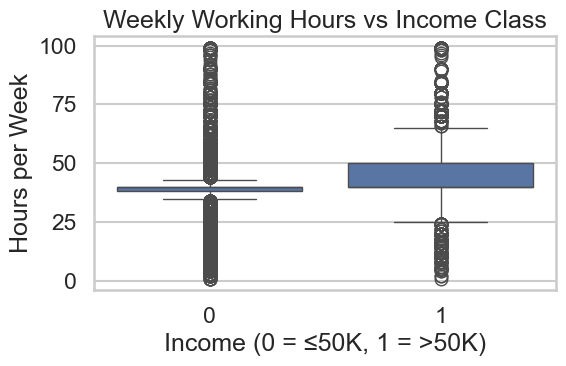

[Info] Hours-per-week correlation saved to: C:\Users\jayap\AI\Income-Prediction-Using-Demographic-Data\reports\hours_per_week_correlation.csv
          feature  point_biserial_correlation  p_value
0  hours-per-week                     0.22905      0.0


In [4]:
# Importance of weekly working hours on earning potential
plt.figure(figsize=(6, 4))
sns.boxplot(
    data=df_clean,
    x="income",
    y="hours-per-week"
)
plt.xlabel("Income (0 = ≤50K, 1 = >50K)")
plt.ylabel("Hours per Week")
plt.title("Weekly Working Hours vs Income Class")
plt.tight_layout()

plt.savefig(VISUALS / "hours_per_week_vs_income_boxplot.png", dpi=150)
plt.show()

# Statistical importance: Point-Biserial Correlation
# --------------------------------------------------
r, p = pointbiserialr(
    df_clean["hours-per-week"],
    df_clean["income"]
)

hours_corr_df = pd.DataFrame(
    {
        "feature": ["hours-per-week"],
        "point_biserial_correlation": [r],
        "p_value": [p],
    }
)

# Save result
corr_path = REPORTS / "hours_per_week_correlation.csv"
hours_corr_df.to_csv(corr_path, index=False)

print("[Info] Hours-per-week correlation saved to:", corr_path)
print(hours_corr_df)

In [5]:
# Features that are highly correlated with income
numeric_cols = [
    "age",
    "education-num",
    "capital-gain",
    "capital-loss",
    "hours-per-week",
]

results = []

for col in numeric_cols:
    r, p = pointbiserialr(df_clean[col], df_clean["income"])
    results.append((col, r, p))

corr_df = pd.DataFrame(
    results,
    columns=["feature", "point_biserial_correlation", "p_value"]
).sort_values("point_biserial_correlation", ascending=False)

# Save to reports directory
corr_path = REPORTS / "point_biserial_correlations.csv"
corr_df.to_csv(corr_path, index=False)

print("[Info] Correlation analysis saved to:", corr_path)
print(corr_df)

[Info] Correlation analysis saved to: C:\Users\jayap\AI\Income-Prediction-Using-Demographic-Data\reports\point_biserial_correlations.csv
          feature  point_biserial_correlation        p_value
1   education-num                    0.337024   0.000000e+00
0             age                    0.256154   0.000000e+00
4  hours-per-week                    0.229050   0.000000e+00
2    capital-gain                    0.220471   0.000000e+00
3    capital-loss                    0.150828  4.804560e-151


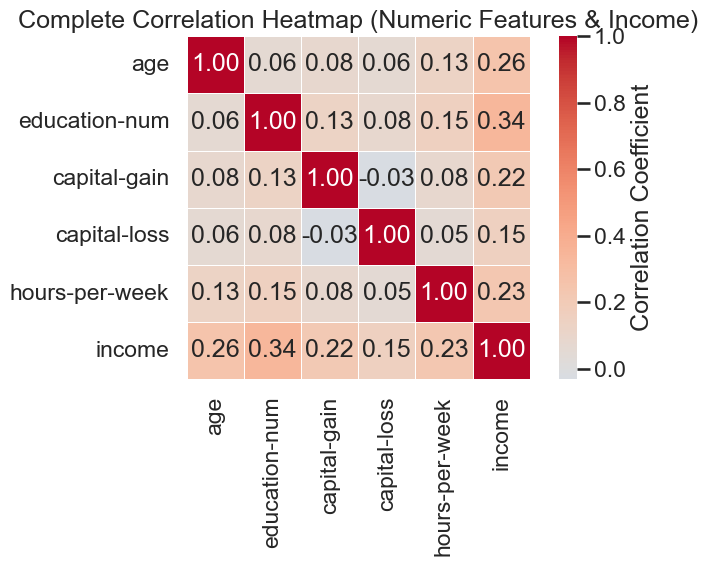

[Info] Heatmap saved to: C:\Users\jayap\AI\Income-Prediction-Using-Demographic-Data\reports\complete_correlation_heatmap.png


In [6]:
numeric_cols = [
    "age",
    "education-num",
    "capital-gain",
    "capital-loss",
    "hours-per-week",
    "income"   # binary target (0/1)
]
corr_matrix = df_clean[numeric_cols].corr(method="pearson")
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))

sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={"label": "Correlation Coefficient"}
)

plt.title("Complete Correlation Heatmap (Numeric Features & Income)")
plt.tight_layout()
heatmap_path = REPORTS / "complete_correlation_heatmap.png"
plt.savefig(heatmap_path, dpi=300, bbox_inches="tight")
plt.show()

print("[Info] Heatmap saved to:", heatmap_path)

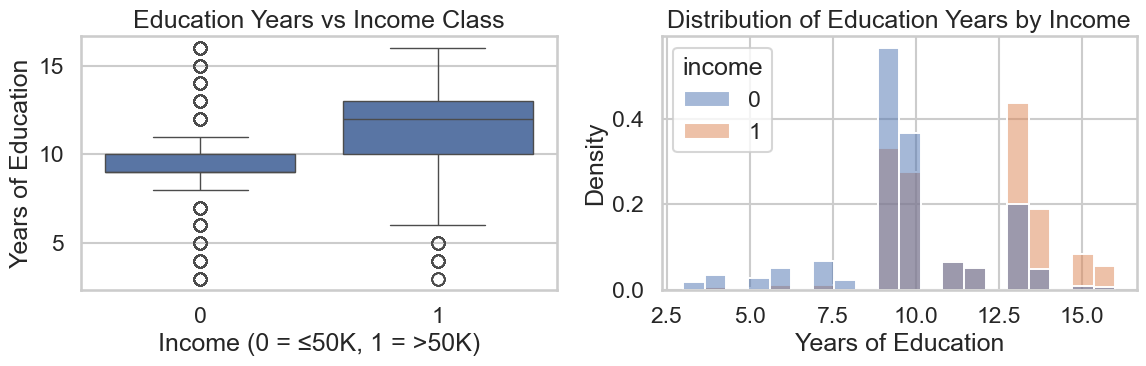

In [7]:
# Education Years vs Income

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# --------------------------------------------------
# Left: Education Years vs Income (Boxplot)
# --------------------------------------------------
sns.boxplot(
    data=df_clean,
    x="income",
    y="education-num",
    ax=axes[0]
)
axes[0].set_xlabel("Income (0 = ≤50K, 1 = >50K)")
axes[0].set_ylabel("Years of Education")
axes[0].set_title("Education Years vs Income Class")

# --------------------------------------------------
# Right: Education Years Distribution by Income
# --------------------------------------------------
sns.histplot(
    data=df_clean,
    x="education-num",
    hue="income",
    bins=20,
    stat="density",
    common_norm=False,
    ax=axes[1]
)
axes[1].set_xlabel("Years of Education")
axes[1].set_ylabel("Density")
axes[1].set_title("Distribution of Education Years by Income")

plt.tight_layout()

# Save BEFORE show
plt.savefig(VISUALS / "education_vs_income.png", dpi=150)
plt.show()


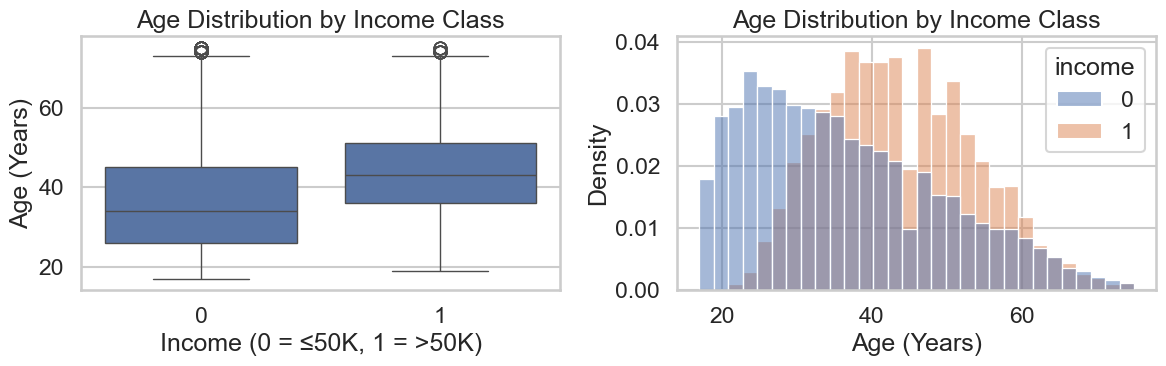

In [8]:
# Age vs Income

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Left: Age vs Income (Boxplot)
sns.boxplot(
    data=df_clean,
    x="income",
    y="age",
    ax=axes[0]
)
axes[0].set_xlabel("Income (0 = ≤50K, 1 = >50K)")
axes[0].set_ylabel("Age (Years)")
axes[0].set_title("Age Distribution by Income Class")

# Right: Age Distribution by Income (Histogram)
sns.histplot(
    data=df_clean,
    x="age",
    hue="income",
    bins=30,
    stat="density",
    common_norm=False,
    ax=axes[1]
)
axes[1].set_xlabel("Age (Years)")
axes[1].set_ylabel("Density")
axes[1].set_title("Age Distribution by Income Class")

plt.tight_layout()

# Save BEFORE show
plt.savefig(VISUALS / "age_vs_income.png", dpi=150)
plt.show()


In [9]:

# Feature Engineering 
# =====================================================
# Start from df_clean to add engineered features
df_fe = df_clean.copy()

# Binary flags
df_fe["is_married"] = df_fe["marital-status"].str.contains("Married", na=False).astype(int)
df_fe["has_capital_gain"] = (df_fe["capital-gain"] > 0).astype(int)
df_fe["has_capital_loss"] = (df_fe["capital-loss"] > 0).astype(int)

# Hours bins (domain-friendly)
def hours_bin(h):
    if pd.isna(h):
        return np.nan
    if h < 35:
        return "Part-time"
    elif h <= 40:
        return "Full-time"
    else:
        return "Overtime"

df_fe["hours_bin"] = df_fe[HOURS_COL].apply(hours_bin)

# Native country collapsed
df_fe["native_us"] = (df_fe["native-country"] == "United-States").astype(int)

# Age groups
df_fe["age_group"] = pd.cut(
    df_fe[AGE_COL],
    bins=[0, 24, 34, 44, 54, 64, 100],
    labels=["<=24", "25-34", "35-44", "45-54", "55-64", "65+"],
)

# Drop rows with NaNs caused by feature engineering
before = len(df_fe)
df_fe = df_fe.dropna(subset=[TARGET_COL]).copy()
print(f"[Info] Dropped {before - len(df_fe)} rows with NaN in target after feature engineering.")

# Drop textual education to avoid duplication
if "education" in df_fe.columns:
    df_fe = df_fe.drop(columns=["education"])

# Explicit target dtype
df_fe[TARGET_COL] = df_fe[TARGET_COL].astype("int8")

fe_path = processed_path / "adult_feature_engineered.csv"
df_fe.to_csv(fe_path, index=False)

print("[Info] Feature-engineered dataset saved to:", fe_path)

[Info] Dropped 0 rows with NaN in target after feature engineering.
[Info] Feature-engineered dataset saved to: C:\Users\jayap\AI\Income-Prediction-Using-Demographic-Data\data\processed\adult_feature_engineered.csv


In [10]:
#  Logistic Regression model
# =====================================================

# Target and feature sets
y_lr = df_fe[TARGET_COL].astype(int)

numeric_features_lr = [
    "age","fnlwgt","education-num",
    "capital-gain","capital-loss",
    "hours-per-week","is_married",
    "has_capital_gain",
    "has_capital_loss","native_us",
]
categorical_features_lr = [
    "workclass","marital-status",
    "occupation","relationship",
    "race","sex","hours_bin",
    "age_group","native-country",
]

X_lr = df_fe[numeric_features_lr + categorical_features_lr]

X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_test_split(
    X_lr, y_lr, test_size=0.20, random_state=42, stratify=y_lr
)

preprocess_lr = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features_lr),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_features_lr),
    ]
)

model_lr = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",
    solver="lbfgs",
)

pipe_lr = Pipeline(steps=[
    ("preprocess", preprocess_lr),
    ("model", model_lr),
])

# Train Logistic Regression model
pipe_lr.fit(X_train_lr, y_train_lr)


,steps,"[('preprocess', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True



=== Logistic Regression Classification report (test) ===
              precision    recall  f1-score   support

           0     0.9422    0.8111    0.8718      4463
           1     0.6014    0.8514    0.7049      1494

    accuracy                         0.8212      5957
   macro avg     0.7718    0.8313    0.7883      5957
weighted avg     0.8567    0.8212    0.8299      5957


=== 5-fold ROC-AUC (Logistic Regression) ===
Mean: 0.913 | Std: 0.004 | Scores: [0.919 0.912 0.915 0.908 0.909]
[Info] Saved: C:\Users\jayap\AI\Income-Prediction-Using-Demographic-Data\reports\feature_importance_permutation_original_logreg.csv

[Info] Importance of weekly working hours related features (engineered, Logistic Regression):
hours_bin         0.008026
hours-per-week    0.000079
dtype: float64

[Info] Logistic Regression model saved to: C:\Users\jayap\AI\Income-Prediction-Using-Demographic-Data\models\logreg_adult.pkl
[Info] Reports saved to: C:\Users\jayap\AI\Income-Prediction-Using-Demographic-

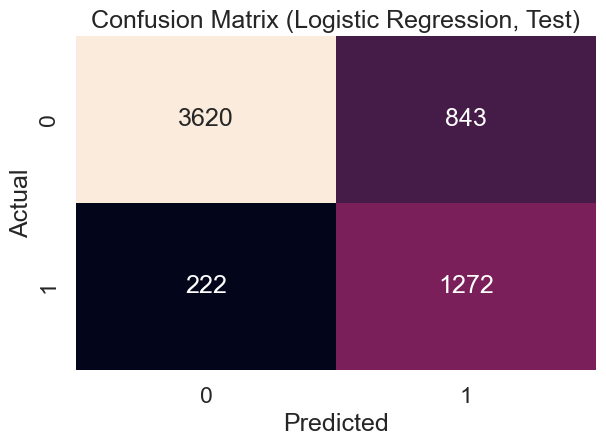

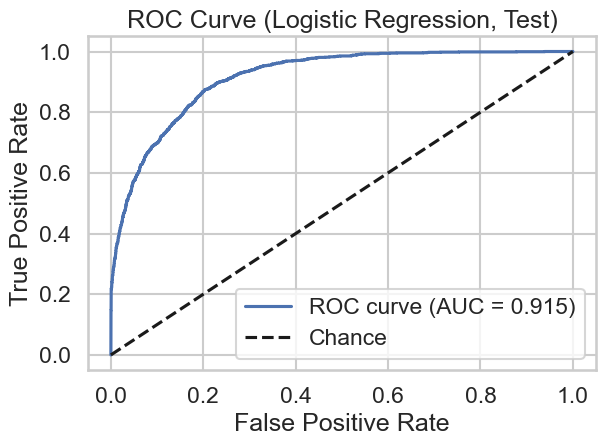

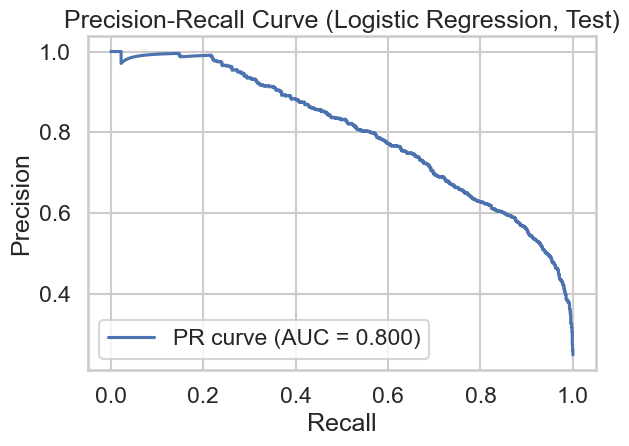

In [11]:

# Evaluation
y_pred_lr = pipe_lr.predict(X_test_lr)
y_prob_lr = pipe_lr.predict_proba(X_test_lr)[:, 1]

print("\n=== Logistic Regression Classification report (test) ===")
print(classification_report(y_test_lr, y_pred_lr, digits=4))

# Confusion matrix
cm = confusion_matrix(y_test_lr, y_pred_lr)
fig_cm, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt="d", cbar=False, ax=ax)
ax.set_title("Confusion Matrix (Logistic Regression, Test)")
ax.set_xlabel("Predicted")
ax.set_ylabel("Actual")
fig_cm.tight_layout()
fig_cm.savefig(VISUALS / "confusion_matrix_logreg.png", dpi=150)

# ROC curve
fpr, tpr, _ = roc_curve(y_test_lr, y_prob_lr)
roc_auc_lr = auc(fpr, tpr)
fig_roc, ax = plt.subplots()
ax.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc_lr:.3f})")
ax.plot([0, 1], [0, 1], "k--", label="Chance")
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.set_title("ROC Curve (Logistic Regression, Test)")
ax.legend(loc="lower right")
fig_roc.tight_layout()
fig_roc.savefig(VISUALS / "roc_curve_logreg.png", dpi=150)

# Precision-Recall curve
prec, rec, _ = precision_recall_curve(y_test_lr, y_prob_lr)
pr_auc_lr = auc(rec, prec)
fig_pr, ax = plt.subplots()
ax.plot(rec, prec, label=f"PR curve (AUC = {pr_auc_lr:.3f})")
ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
ax.set_title("Precision-Recall Curve (Logistic Regression, Test)")
ax.legend(loc="lower left")
fig_pr.tight_layout()
fig_pr.savefig(VISUALS / "pr_curve_logreg.png", dpi=150)

# Cross-validated ROC-AUC for generalization check (Logistic Regression)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores_lr = cross_val_score(pipe_lr, X_lr, y_lr, cv=cv, scoring="roc_auc")
print(f"\n=== 5-fold ROC-AUC (Logistic Regression) ===")
print(f"Mean: {cv_scores_lr.mean():.3f} | Std: {cv_scores_lr.std():.3f} | Scores: {np.round(cv_scores_lr, 3)}")

# Permutation importance (original engineered features) for Logistic Regression
result_lr = permutation_importance(
    pipe_lr,X_test_lr,
    y_test_lr,n_repeats=10,
    random_state=42,
    scoring="roc_auc",
)

feature_names_lr = X_test_lr.columns
importances_lr = pd.Series(result_lr.importances_mean, index=feature_names_lr).sort_values(ascending=False)

fi_path = REPORTS / "feature_importance_permutation_original_logreg.csv"
importances_lr.to_csv(fi_path)
print(f"[Info] Saved: {fi_path}")

# Hours-related importance in engineered space
hours_related_lr = importances_lr[importances_lr.index.str.contains(r"hours-per-week|hours_bin", case=False, regex=True)]
print("\n[Info] Importance of weekly working hours related features (engineered, Logistic Regression):")
print(hours_related_lr)

# Save Logistic Regression model
models_dir = root / "models"
models_dir.mkdir(parents=True, exist_ok=True)
model_path = models_dir / "logreg_adult.pkl"
joblib.dump(pipe_lr, model_path)
print(f"\n[Info] Logistic Regression model saved to: {model_path}")
print(f"[Info] Reports saved to: {REPORTS}")



In [12]:

# 5. RandomForest model with preprocessing (df_clean)
# =====================================================

# Identify numeric vs categorical features from df_fe
num_cols = df_fe.select_dtypes(include=["int64", "float64", "int32", "float32", "int8"]).columns.tolist()
cat_cols = df_fe.select_dtypes(include=["object", "category"]).columns.tolist()

# Remove target from feature lists
num_cols = [c for c in num_cols if c != TARGET_COL]
cat_cols = [c for c in cat_cols if c != TARGET_COL]

X_rf = df_fe.drop(columns=[TARGET_COL])
y_rf = df_fe[TARGET_COL]

numeric_transformer = Pipeline(steps=[
    ("scaler", StandardScaler())
])
categorical_transformer = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
preprocessor_rf = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, [c for c in num_cols if c in X_rf.columns]),
        ("cat", categorical_transformer, [c for c in cat_cols if c in X_rf.columns]),
    ],
    remainder="drop",
)
clf_rf = Pipeline(steps=[
    ("preprocess", preprocessor_rf),
    ("model", RandomForestClassifier(
        n_estimators=300,random_state=42,
        class_weight="balanced",
        n_jobs=-1,
    )),
])

X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(
    X_rf, y_rf, test_size=0.25, random_state=42, stratify=y_rf
)
clf_rf.fit(X_train_rf, y_train_rf)


,steps,"[('preprocess', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True



=== RandomForest Classification report (test) ===
              precision    recall  f1-score   support

           0       0.88      0.93      0.90      5578
           1       0.74      0.63      0.68      1868

    accuracy                           0.85      7446
   macro avg       0.81      0.78      0.79      7446
weighted avg       0.85      0.85      0.85      7446

ROC-AUC (RandomForest): 0.905

=== 5-fold ROC-AUC (RandomForest) ===
Mean: 0.903 | Std: 0.002 | Scores: [0.905 0.899 0.906 0.901 0.903]
[Info] Saved: C:\Users\jayap\AI\Income-Prediction-Using-Demographic-Data\reports\feature_importance_permutation_original_rf.csv

[Info] Importance of weekly working hours related features (engineered, RandomForest):
hours_bin         0.001037
hours-per-week   -0.000181
dtype: float64


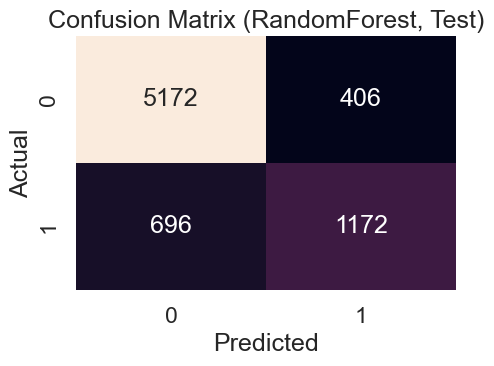

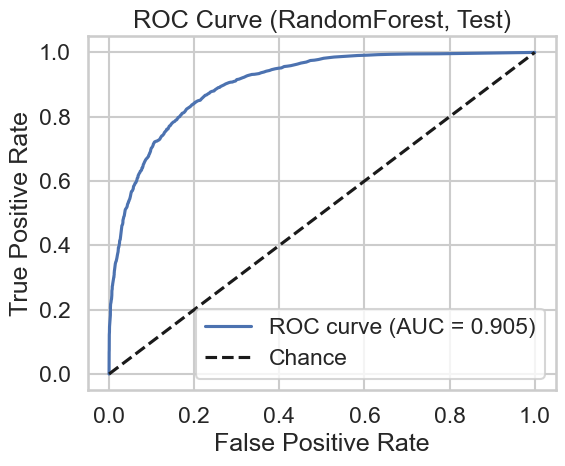

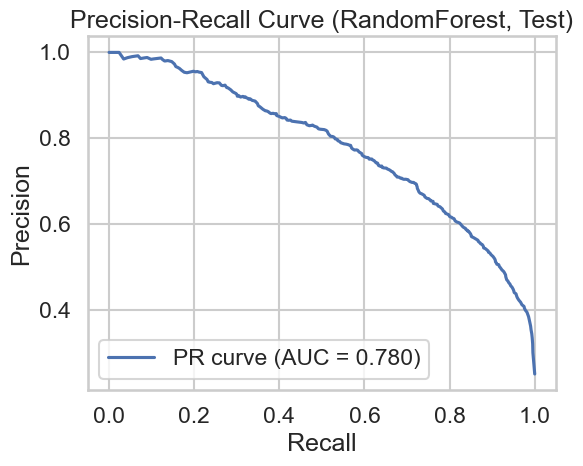

In [13]:

# Evaluation
y_pred_rf = clf_rf.predict(X_test_rf)
y_prob_rf = clf_rf.predict_proba(X_test_rf)[:, 1]
print("\n=== RandomForest Classification report (test) ===")
print(classification_report(y_test_rf, y_pred_rf))
roc_auc_rf = roc_auc_score(y_test_rf, y_prob_rf)
print(f"ROC-AUC (RandomForest): {roc_auc_rf:.3f}")

# Confusion matrix
cm = confusion_matrix(y_test_rf, y_pred_rf)
fig_cm, ax = plt.subplots(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cbar=False, ax=ax)
ax.set_title("Confusion Matrix (RandomForest, Test)")
ax.set_xlabel("Predicted")
ax.set_ylabel("Actual")
fig_cm.tight_layout()
fig_cm.savefig(VISUALS / "confusion_matrix_rf.png", dpi=150)
# ROC curve
fpr, tpr, _ = roc_curve(y_test_rf, y_prob_rf)
roc_auc_rf = auc(fpr, tpr)
fig_roc, ax = plt.subplots(figsize=(6, 5))
ax.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc_rf:.3f})")
ax.plot([0, 1], [0, 1], "k--", label="Chance")
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.set_title("ROC Curve (RandomForest, Test)")
ax.legend(loc="lower right")
fig_roc.tight_layout()
fig_roc.savefig(VISUALS / "roc_curve_rf.png", dpi=150)

# Precision-Recall curve
prec, rec, _ = precision_recall_curve(y_test_rf, y_prob_rf)
pr_auc_rf = auc(rec, prec)
fig_pr, ax = plt.subplots(figsize=(6, 5))
ax.plot(rec, prec, label=f"PR curve (AUC = {pr_auc_rf:.3f})")
ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
ax.set_title("Precision-Recall Curve (RandomForest, Test)")
ax.legend(loc="lower left")
fig_pr.tight_layout()
fig_pr.savefig(VISUALS / "pr_curve_rf.png", dpi=150)

# Cross-validated ROC-AUC for generalization check (RandomForest)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores_rf = cross_val_score(clf_rf, X_rf, y_rf, cv=cv, scoring="roc_auc")
print(f"\n=== 5-fold ROC-AUC (RandomForest) ===")
print(f"Mean: {cv_scores_rf.mean():.3f} | Std: {cv_scores_rf.std():.3f} | Scores: {np.round(cv_scores_rf, 3)}")
# Permutation importance (original engineered features) for Logistic Regression
result_rf = permutation_importance(
    clf_rf,
    X_test_rf,
    y_test_rf,
    n_repeats=10,
    random_state=42,
    scoring="roc_auc",
)
feature_names_rf = X_test_rf.columns
importances_rf = pd.Series(result_rf.importances_mean, index=feature_names_rf).sort_values(ascending=False)
fi_path = REPORTS / "feature_importance_permutation_original_rf.csv"
importances_rf.to_csv(fi_path)
print(f"[Info] Saved: {fi_path}")

# Hours-related importance in engineered space
hours_related_rf = importances_rf[importances_rf.index.str.contains(r"hours-per-week|hours_bin", case=False, regex=True)]
print("\n[Info] Importance of weekly working hours related features (engineered, RandomForest):")
print(hours_related_rf)

In [14]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

acc_lr = accuracy_score(y_test_lr, y_pred_lr)
prec_lr = precision_score(y_test_lr, y_pred_lr)
rec_lr = recall_score(y_test_lr, y_pred_lr)
f1_lr = f1_score(y_test_lr, y_pred_lr)

print(f"Accuracy_lr : {acc_lr:.3f}")
print(f"Precision_lr: {prec_lr:.3f}")
print(f"Recall_lr   : {rec_lr:.3f}")
print(f"F1-score_lr : {f1_lr:.3f}")

acc_rf = accuracy_score(y_test_rf, y_pred_rf)
prec_rf = precision_score(y_test_rf, y_pred_rf)
rec_rf = recall_score(y_test_rf, y_pred_rf)
f1_rf = f1_score(y_test_rf, y_pred_rf)

print(f"\nAccuracy_rf : {acc_rf:.3f}")
print(f"Precision_rf: {prec_rf:.3f}")
print(f"Recall_rf   : {rec_rf:.3f}")
print(f"F1-score_rf : {f1_rf:.3f}")
# =====================================================
# 11. Wrap-up: Save summary metrics
# =====================================================
summary = {
    "rows_after_cleaning": int(df_clean.shape[0]),
    "roc_auc_random_forest": float(roc_auc_rf),
    "pr_auc_random_forest": float(pr_auc_rf),
    "roc_auc_logistic": float(roc_auc_lr),
    "pr_auc_logistic": float(pr_auc_lr),
    "hours_feature_in_dataset": HOURS_COL in df_clean.columns,
    "education_years_feature_in_dataset": EDU_YEARS_COL in df_clean.columns,
    "age_feature_in_dataset": AGE_COL in df_clean.columns,
}

summary_path = REPORTS / "summary_metrics.csv"
pd.Series(summary).to_csv(summary_path)
print(f"[Info] Saved summary metrics to: {summary_path}")


Accuracy_lr : 0.821
Precision_lr: 0.601
Recall_lr   : 0.851
F1-score_lr : 0.705

Accuracy_rf : 0.852
Precision_rf: 0.743
Recall_rf   : 0.627
F1-score_rf : 0.680
[Info] Saved summary metrics to: C:\Users\jayap\AI\Income-Prediction-Using-Demographic-Data\reports\summary_metrics.csv


In [21]:
# generate_eda_6panel.py
import os

sns.set(style="whitegrid", context="talk", palette="deep")

# === CONFIG ===
CLEANED_CSV = processed_path/"adult_cleaned.csv"  # change if needed
OUT_DIR = root/"visuals"
OUT_NAME = "EDA_Panel_Visualization.png"
OUT_PATH = os.path.join(OUT_DIR, OUT_NAME)
DPI = 200

os.makedirs(OUT_DIR, exist_ok=True)

# === LOAD DATA ===
df = pd.read_csv(CLEANED_CSV)

# Ensure numeric types
for c in ["age", "education-num", "hours-per-week", "capital-gain", "capital-loss"]:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

# If target is still text, map to 0/1
if "income" in df.columns and df["income"].dtype == object:
    df["income"] = df["income"].str.replace(r"\.$", "", regex=True).str.strip()
    df["income"] = df["income"].map({">50K": 1, "<=50K": 0})

# Small helpers for plotting
def pct_fmt(x, pos=None):
    return f"{int(x)}"

# === PLOT ===
fig, axes = plt.subplots(2, 3, figsize=(21,14))
axes = axes.ravel()

# 1) Age distribution
sns.histplot(df["age"].dropna(), bins=30, ax=axes[0], kde=False)
axes[0].set_title("Age distribution")
axes[0].set_xlabel("Age")
axes[0].set_ylabel("Count")

# 2) Education-num distribution
sns.histplot(df["education-num"].dropna(), bins=20, ax=axes[1], kde=False)
axes[1].set_title("Education-years (education-num)")
axes[1].set_xlabel("Education years")
axes[1].set_ylabel("Count")

# 3) Hours-per-week distribution (peak at 40)
sns.histplot(df["hours-per-week"].dropna(), bins=25, ax=axes[2], kde=False)
axes[2].set_title("Hours per week")
axes[2].set_xlabel("Hours/week")
axes[2].axvline(40, color="black", linestyle="--", linewidth=1)
axes[2].set_ylabel("Count")

# 4) Income vs Age (boxplot)
sns.boxplot(x=df["income"].map({0:"<=50K", 1:">50K"}), y=df["age"], ax=axes[3])
axes[3].set_title("Age by Income class")
axes[3].set_xlabel("Income")
axes[3].set_ylabel("Age")

# 5) Income vs Education-num (boxplot)
sns.boxplot(x=df["income"].map({0:"<=50K", 1:">50K"}), y=df["education-num"], ax=axes[4])
axes[4].set_title("Education years by Income class")
axes[4].set_xlabel("Income")
axes[4].set_ylabel("Education years")

# 6) Capital-gain distribution (log scale for non-zero)
# show zeros separately and log-scale histogram for non-zero values
cap_nonzero = df.loc[df["capital-gain"] > 0, "capital-gain"].dropna()
if len(cap_nonzero) > 0:
    axes[5].hist(np.log1p(cap_nonzero), bins=30)
    axes[5].set_title("Capital-gain (log(1+x) of >0 values)")
    axes[5].set_xlabel("log(1 + capital-gain)")
    axes[5].set_ylabel("Count")
else:
    axes[5].text(0.5, 0.5, "Most capital-gain == 0\nNo non-zero values to plot",
                 ha="center", va="center", fontsize=12)
    axes[5].set_axis_off()

plt.tight_layout()
plt.subplots_adjust(top=0.94)
# Save
plt.savefig(OUT_PATH, dpi=DPI, bbox_inches="tight")
print(f"Saved EDA figure to: {OUT_PATH}")
plt.close(fig)


Saved EDA figure to: C:\Users\jayap\AI\Income-Prediction-Using-Demographic-Data\visuals\EDA_Panel_Visualization.png


In [16]:
# generate_three_plots.py
# Generates 3 PNGs:
#  - outlier_distribution.png
#  - mutual_information.png
#  - additional_stats.png
#
# Usage:
#   python generate_three_plots.py

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import mutual_info_classif

sns.set(style="whitegrid", context="talk", palette="deep")

# ===== CONFIG =====
CLEANED_CSV = r"C:\Users\jayap\AI\capstone_project\data\processed\adult_cleaned.csv"
OUT_DIR = r"C:\Users\jayap\AI\capstone_project\visuals"
os.makedirs(OUT_DIR, exist_ok=True)
DPI = 200

# ===== LOAD =====
df = pd.read_csv(CLEANED_CSV)

# Ensure numeric columns exist and are numeric
num_cols = ["age", "education-num", "hours-per-week", "capital-gain", "capital-loss"]
for c in num_cols:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

# Map income to 0/1 if needed
if "income" in df.columns and df["income"].dtype == object:
    df["income"] = df["income"].astype(str).str.replace(r"\.$", "", regex=True).str.strip()
    df["income"] = df["income"].map({">50K": 1, "<=50K": 0})

# ===== PNG 1: Outlier Distribution (3-panel boxplots) =====
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
sns.boxplot(y=df["age"].dropna(), ax=axes[0])
axes[0].set_title("Age Outlier Boxplot")
axes[0].set_xlabel("")
axes[0].set_ylabel("Age")

sns.boxplot(y=df["education-num"].dropna(), ax=axes[1])
axes[1].set_title("Education-num Outlier Boxplot")
axes[1].set_xlabel("")
axes[1].set_ylabel("Education years")

sns.boxplot(y=df["hours-per-week"].dropna(), ax=axes[2])
axes[2].set_title("Hours-per-week Outlier Boxplot")
axes[2].set_xlabel("")
axes[2].set_ylabel("Hours/week")

plt.tight_layout()
out1 = os.path.join(OUT_DIR, "outlier_distribution.png")
plt.savefig(out1, dpi=DPI, bbox_inches="tight")
plt.close()
print("Saved:", out1)

# ===== PNG 2: Mutual Information Barplot =====
# Prepare transformed features: use numeric + simple ordinal encoding for a few categoricals if present
X_mi = df.copy()
y_mi = X_mi["income"].astype(int) if "income" in X_mi.columns else None

# For mutual_info_classif we need numeric matrix: encode a few categorical columns coarsely
cat_cols = X_mi.select_dtypes(include=["object", "category"]).columns.tolist()
# choose small set of categorical columns if present to avoid explosion
cat_cols = [c for c in cat_cols if c in ["workclass", "occupation", "marital-status", "relationship", "race", "sex", "native-country"]]
X_mi_enc = X_mi[num_cols].copy()
for c in cat_cols:
    X_mi_enc[c] = X_mi[c].astype("category").cat.codes

# Remove rows with NaNs in X or y
mi_mask = X_mi_enc.notna().all(axis=1)
if y_mi is not None:
    mi_mask &= y_mi.notna()
X_mi_enc = X_mi_enc.loc[mi_mask]
y_mi = y_mi.loc[mi_mask]

mi_vals = mutual_info_classif(X_mi_enc, y_mi, random_state=42, discrete_features='auto')
mi_index = X_mi_enc.columns.tolist()
mi_series = pd.Series(mi_vals, index=mi_index).sort_values(ascending=False)

# plot top 8 features (or fewer)
top_n = min(8, len(mi_series))
fig, ax = plt.subplots(figsize=(8, 5))
sns.barplot(x=mi_series.values[:top_n], y=mi_series.index[:top_n], ax=ax)
ax.set_title("Mutual Information (top features)")
ax.set_xlabel("Mutual Information")
ax.set_ylabel("Feature")
plt.tight_layout()
out2 = os.path.join(OUT_DIR, "mutual_information.png")
plt.savefig(out2, dpi=DPI, bbox_inches="tight")
plt.close()
print("Saved:", out2)

# ===== PNG 3: Additional Statistical Insights (3-panel counts) =====
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
# Income distribution
if "income" in df.columns:
    sns.countplot(x=df["income"].map({0:"<=50K", 1:">50K"}), ax=axes[0])
    axes[0].set_title("Income Distribution")
    axes[0].set_xlabel("Income")
else:
    axes[0].text(0.5, 0.5, "Income not available", ha="center")

# Age group distribution (<=35 / 36+)
age_group = np.where(df["age"] >= 35, "35+", "≤34")
sns.countplot(x=age_group, ax=axes[1])
axes[1].set_title("Age group distribution")
axes[1].set_xlabel("Age group")

# Education category: high vs low (>=12 yrs)
edu_cat = np.where(df["education-num"] >= 12, "High Edu (>=12)", "Low Edu (<12)")
sns.countplot(x=edu_cat, ax=axes[2])
axes[2].set_title("Education categories")
axes[2].set_xlabel("Education")

plt.tight_layout()
out3 = os.path.join(OUT_DIR, "additional_stats.png")
plt.savefig(out3, dpi=DPI, bbox_inches="tight")
plt.close()
print("Saved:", out3)

print("All images created in:", OUT_DIR)


Saved: C:\Users\jayap\AI\capstone_project\visuals\outlier_distribution.png
Saved: C:\Users\jayap\AI\capstone_project\visuals\mutual_information.png
Saved: C:\Users\jayap\AI\capstone_project\visuals\additional_stats.png
All images created in: C:\Users\jayap\AI\capstone_project\visuals


In [17]:
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
print(classification_report(y_test_lr, y_pred_lr, digits=4))
roc_auc = roc_auc_score(y_test_lr, y_prob_lr)
cm = confusion_matrix(y_test_lr, y_pred_lr)
print("ROC AUC:", roc_auc)
print("Confusion matrix:\n", cm)


              precision    recall  f1-score   support

           0     0.9422    0.8111    0.8718      4463
           1     0.6014    0.8514    0.7049      1494

    accuracy                         0.8212      5957
   macro avg     0.7718    0.8313    0.7883      5957
weighted avg     0.8567    0.8212    0.8299      5957

ROC AUC: 0.9148685263122849
Confusion matrix:
 [[3620  843]
 [ 222 1272]]


In [18]:
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
print(classification_report(y_test_rf, y_pred_rf, digits=4))
roc_auc = roc_auc_score(y_test_rf, y_prob_rf)
cm = confusion_matrix(y_test_rf, y_pred_rf)
print("ROC AUC:", roc_auc)
print("Confusion matrix:\n", cm)


              precision    recall  f1-score   support

           0     0.8814    0.9272    0.9037      5578
           1     0.7427    0.6274    0.6802      1868

    accuracy                         0.8520      7446
   macro avg     0.8121    0.7773    0.7920      7446
weighted avg     0.8466    0.8520    0.8476      7446

ROC AUC: 0.9048457614534924
Confusion matrix:
 [[5172  406]
 [ 696 1172]]


In [19]:
from sklearn.metrics import auc, precision_recall_curve
prec, rec, _ = precision_recall_curve(y_test_lr, y_prob_lr)
pr_auc = auc(rec, prec)
print("PR-AUC:", pr_auc)


PR-AUC: 0.7996711492757509


In [20]:
from sklearn.metrics import auc, precision_recall_curve
prec, rec, _ = precision_recall_curve(y_test_rf, y_prob_rf)
pr_auc = auc(rec, prec)
print("PR-AUC:", pr_auc)


PR-AUC: 0.7802193073511898
